In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, HuberRegressor, TheilSenRegressor, RANSACRegressor
from sklearn.preprocessing import PolynomialFeatures, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingRegressor
from sklearn.feature_selection import RFECV

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# csv fayllarni yuklab olamiz

In [2]:
df = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

# train datasetni jins ustunini one-hot encoding qilamiz pandas orqali

In [3]:
df = pd.get_dummies(df, columns=['Sex'], dtype=int)
df = df.drop('Sex_Diameter', axis=1)
df

,id,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age,Sex_F,Sex_I,Sex_M
0,0,0.5500,0.4125,0.1625,1.715145,0.609514,0.396893,0.566990,4.0,0,1,0
1,1,1.5125,1.2125,0.4000,31.312023,13.395139,6.265239,8.930093,10.0,1,0,0
2,2,1.5125,1.1750,0.4125,31.552993,14.670866,6.279414,9.922325,11.0,1,0,0
3,3,0.8000,0.6000,0.2000,4.620969,3.019222,0.978058,1.417475,7.0,0,1,0
4,4,1.3875,1.0875,0.3625,24.323871,11.651644,5.712424,5.386405,8.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
14995,14995,1.3750,1.0625,0.3500,24.734939,11.169703,6.208540,6.095142,9.0,0,0,1
14996,14996,1.0750,0.8125,0.2500,12.998246,5.896696,2.338834,2.919999,7.0,0,1,0
14997,14997,1.3750,1.1125,0.3625,23.544260,8.674947,4.791066,7.796112,15.0,0,1,0
14998,14998,1.4375,1.1125,0.3500,28.448723,14.571643,6.279414,6.803880,10.0,0,0,1


# train datasetida qaysi ustunlarni one-hot encoding qilsak test datasetni ustida ham shu ishlarni amalga oshiramiz

In [4]:
test = pd.get_dummies(test, columns=['Sex'], dtype=int)

# datasetni yoshga nisbatan korelatsiyasini ko'ramiz

In [5]:
df.corr()['Age']

id               -0.004924
Length            0.628870
Diameter          0.635549
Height            0.670477
Weight            0.618143
Shucked Weight    0.509258
Viscera Weight    0.588998
Shell Weight      0.685685
Age               1.000000
Sex_F             0.308692
Sex_I            -0.533182
Sex_M             0.228801
Name: Age, dtype: float64

# ma'lumotlarni boxplot orqali outlayerlar bor yoqligini ko'ramiz 

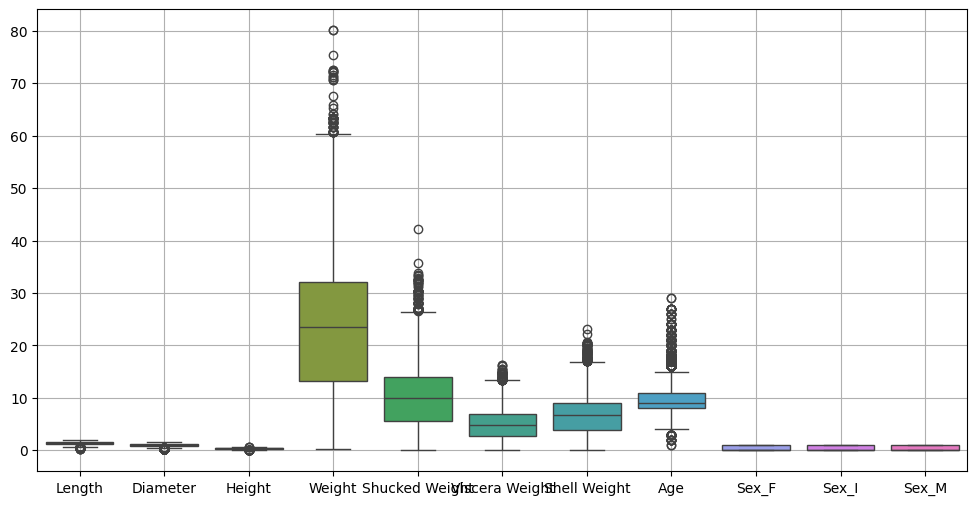

In [6]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df.drop(['id'],axis=1))
plt.grid()

In [7]:
X = df.drop(['id', 'Age'], axis=1)
y = df['Age']

test_data = test.drop('id', axis=1)

test_data.shape, X.shape

((10000, 10), (15000, 10))

# for sikl orqali har modelni mae ko'rib chiqamiz 

In [8]:
regressors = {
    "Linear": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "Huber": HuberRegressor(),
    "TheilSen": TheilSenRegressor(),
    "Ransac": RANSACRegressor()
}

results = []

for regressor_name, regressor in regressors.items():
    regressor.fit(X, y)
    predictions = regressor.predict(X)
    MAE = mean_absolute_error(y, predictions)
    
    results.append({
        'Model': regressor_name,
        'MAE': MAE
    })

pd.DataFrame(results).sort_values('MAE')


,Model,MAE
4,Huber,1.370570
5,TheilSen,1.378964
1,Ridge,1.404953
0,Linear,1.405137
6,Ransac,1.414535
3,ElasticNet,1.563978
2,Lasso,1.677874


# sikl orqali har bir modelni polynomial fuatures orqali qaysi darajada maesi nechi ekanligini ko'ramiz

In [9]:
results = []
for d in range(1, 4):
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X)

    regressors = {
        "Linear": LinearRegression(),
        "Ridge": Ridge(),
        "Lasso": Lasso(),
        "ElasticNet": ElasticNet(),
        "Huber": HuberRegressor(),
        "TheilSen": TheilSenRegressor(),
        "Ransac": RANSACRegressor()
    }


    for regressor_name, regressor in regressors.items():
        regressor.fit(X_poly, y)
        predictions = regressor.predict(X_poly)
        MAE = mean_absolute_error(y, predictions)
    
        results.append({
            'Model': regressor_name,
            'MAE': MAE,
            'Poly degree': d
        })

pd.DataFrame(results).sort_values('MAE')

,Model,MAE,Poly degree
14,Linear,1.328690,3
15,Ridge,1.329433,3
7,Linear,1.354609,2
8,Ridge,1.355562,2
12,TheilSen,1.359371,2
4,Huber,1.369787,1
5,TheilSen,1.381073,1
19,TheilSen,1.388846,3
1,Ridge,1.404953,1
0,Linear,1.405137,1


# jadvaldagi ma'lumotlarga qarab har bir modelga polynomial darajasini berib chiqamiz 

In [10]:
linear_pipeline   = Pipeline([('poly', PolynomialFeatures(degree=3)),
                              ('model', LinearRegression())])

ridge_pipeline    = Pipeline([('poly', PolynomialFeatures(degree=3)),
                              ('model', Ridge())])

lasso_pipeline    = Pipeline([('poly', PolynomialFeatures(degree=3)),
                              ('model', Lasso())])

huber_pipeline    = Pipeline([('poly', PolynomialFeatures(degree=1)),
                              ('model', HuberRegressor())])

theilsen_pipeline = Pipeline([('poly', PolynomialFeatures(degree=2)),
                              ('model', TheilSenRegressor())])


# stacking regressorni oxirida qaysi modelni qo'llashni aniqlaymiz 

In [11]:
results = []
for regressor_name, regressor in regressors.items():
    stacking_regressor = StackingRegressor(
        estimators=[
            ('linear', linear_pipeline), 
            ('ridge', ridge_pipeline), 
            ('lasso', lasso_pipeline),
            ('huber', huber_pipeline), 
            ('theilsen', theilsen_pipeline)
        ],
        final_estimator=regressor,
        cv=5,
        passthrough=True
    )

    stacking_regressor.fit(X, y)

    MAE = mean_absolute_error(y, stacking_regressor.predict(X))

    results.append({
        'Model': regressor_name,
        'MAE': MAE
    })

pd.DataFrame(results).sort_values('MAE')

,Model,MAE
4,Huber,1.306261
5,TheilSen,1.320013
0,Linear,1.331677
1,Ridge,1.331701
3,ElasticNet,1.352114
2,Lasso,1.387852
6,Ransac,1.513084


# jadvaldagi ma'lumotlar bo'yicha huber regressor eng yaxshi maeni chiqarar ekan 

In [16]:
stacking_regressor = StackingRegressor(
    estimators=[
        ('linear', linear_pipeline), 
        ('ridge', ridge_pipeline), 
        ('lasso', lasso_pipeline),
        ('huber', huber_pipeline), 
        ('theilsen', theilsen_pipeline)
    ],
    final_estimator=HuberRegressor(),
    cv=5,
    passthrough=True
)

stacking_regressor.fit(X, y)

y_pred_stacking = stacking_regressor.predict(test_data)
mean_absolute_error(y, stacking_regressor.predict(X))

np.float64(1.306940193105443)

In [17]:
sample = pd.read_csv('sample_submission.csv')
sample['Age'] = np.round(y_pred_stacking)
sample.to_csv('imtihon.csv', index=False)